## Final Project for "📸👁️Introduction to Computer Vision" - Классификация опухолей головного мозга с помощью МРТ(Магнитно-резонансная томография)-сканирования

### 0. 📥 Imports

In [2]:
# Importing necessary libraries
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import tensorflow as tf
from tensorflow import keras
import PIL
import pathlib
import PIL.Image
import warnings
from datetime import datetime
import random
from pathlib import Path
# Импортируем необходимые библиотеки
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D, 
    BatchNormalization, 
    Activation, 
    MaxPooling2D, 
    Dense, 
    GlobalAveragePooling2D, 
    Add,
)

# Disable warnings for cleaner output
warnings.filterwarnings("ignore")


### 1. 📊 Dataset Selection:

### **Обзор набора данных** 

Всего **7023 МРТ-сканов мозга**, разделенных на четыре класса.
1. **Glioma - Глиома**: 1,621 изображения {./dataset/glioma} 
2. **Healthy - Здоровый**: 2,000 изображения {./dataset/healthy}
3. **Meningioma - Менингиома**: 1,645 изображения {./dataset/meningioma} 
4. **Pituitary - Гипофиз**: 1,757 изображения {./dataset/pituitary}

Каждое изображение **изображение RGB размером 224x224 пикселей**, что обеспечивает достаточное разрешение для извлечения признаков с использованием методов глубокого обучения.
 
Для классификации этих изображений можно использовать трансферное обучение и сверточные нейронные сети, что может спасти жизни пациентов благодаря ранней диагностике опухолей.

Мой выбор попал на датасет из Кагл - так как я могу демонстрировать свои знания и могу работать так и классификации и сегментацией опухулей что возможно будет и для меня и для других полезным. Классифицируйте результаты МРТ как глиому, менингиому, гипофиз или здоровые.

In [ ]:
# аутентификация с токеном - расположенный на пути C:\Users\Qarlygash\.kaggle\kaggle.json
api = KaggleApi()
api.authenticate()

# Download the dataset
api.dataset_download_files("rm1000/brain-tumor-mri-scans", path="./dataset", unzip=True)

In [3]:
dataset_path = "./dataset"
classes = ["glioma", "healthy", "meningioma", "pituitary"]

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    num_images = len(os.listdir(class_path))
    print(f"{cls.capitalize()}: {num_images} images")


Glioma: 1621 images
Healthy: 2000 images
Meningioma: 1645 images
Pituitary: 1757 images


### **🎯 Objective**

The primary objective of this project is to leverage **Convolutional Neural Networks (CNNs)** to develop a robust model capable of:  
1. **🔍 Classifying Brain MRI Scans** into one of four categories: Glioma, Healthy, Meningioma, and Pituitary.  
2. **⚡ Improving Early Diagnosis** of brain tumors by identifying patterns in MRI scans that distinguish between tumor types and healthy scans.  
3. **📈 Enhancing Diagnostic Accuracy** to assist healthcare professionals in making timely and tion in healthcare systems.  

This project has the potential to **save lives** by supporting early and accurate tumor diagnosis, thereby improving treatment outcomes. 🌟

### 2. 🔄 Data Preprocessing:

In [163]:
# Параметры
random.seed(42)
BATCH_SIZE = 2
IMAGE_SIZE = (224, 224)
dataset_path = "./dataset"
classes = ["glioma", "healthy", "meningioma", "pituitary"]

In [137]:
# # Функция для разделения данных
# def split_data():
#     train_data = []
#     val_data = []
#     test_data = []

#     for cls in classes:
#         class_dir = os.path.join(dataset_path, cls)
#         images = os.listdir(class_dir)

#         # Разделение на train, validation, test
#         num_images = len(images)
#         train_split = int(num_images * 0.8)
#         val_split = int(num_images * 0.9)

#         train_images = images[:train_split]
#         val_images = images[train_split:val_split]
#         test_images = images[val_split:]

#         train_data.extend([(os.path.join(class_dir, img), cls) for img in train_images])
#         val_data.extend([(os.path.join(class_dir, img), cls) for img in val_images])
#         test_data.extend([(os.path.join(class_dir, img), cls) for img in test_images])

#     return train_data, val_data, test_data

# # Подготовка датасета для TensorFlow
# def prepare_dataset(data):
#     file_paths, labels = zip(*data)
#     labels = tf.keras.utils.to_categorical([classes.index(label) for label in labels], num_classes=len(classes))

#     dataset = tf.data.Dataset.from_tensor_slices((list(file_paths), labels))

#     # Преобразование изображений
#     dataset = dataset.map(lambda x, y: (tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(x), channels=3), IMAGE_SIZE), y))
#     dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
#     return dataset

# # Разделение данных
# train_data, val_data, test_data = split_data()

# # Подготовка наборов данных
# train_ds = prepare_dataset(train_data)
# val_ds = prepare_dataset(val_data)
# test_ds = prepare_dataset(test_data)


In [167]:
def split_data():
    train_data = []
    val_data = []
    test_data = []

    for cls in classes:
        class_dir = os.path.join(dataset_path, cls)
        images = os.listdir(class_dir)

        # Разделение на train, validation, test
        num_images = len(images)
        train_split = int(num_images * 0.8)
        val_split = int(num_images * 0.9)

        train_images = images[:train_split]
        val_images = images[train_split:val_split]
        test_images = images[val_split:]

        train_data.extend([(os.path.join(class_dir, img), cls) for img in train_images])
        val_data.extend([(os.path.join(class_dir, img), cls) for img in val_images])
        test_data.extend([(os.path.join(class_dir, img), cls) for img in test_images])

    return train_data, val_data, test_data

# Функция для обработки изображений (с изменением размера, нормализацией и аугментацией)
def prepare_dataset(data, is_train=False):
    file_paths, labels = zip(*data)
    labels = tf.keras.utils.to_categorical([classes.index(label) for label in labels], num_classes=len(classes))

    dataset = tf.data.Dataset.from_tensor_slices((list(file_paths), labels))

    # Преобразование изображений с аугментацией для тренировочных данных
    def process_image(file_path, label):
        image = tf.image.decode_jpeg(tf.io.read_file(file_path), channels=3)
        image = tf.image.resize(image, IMAGE_SIZE)

        # Нормализация изображений (диапазон [0, 1])
        image = image / 255.0

        # Аугментация для тренировочных данных
        if is_train:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_flip_up_down(image)

        # Нормализация изображения: (среднее, стандартное отклонение)
        mean = [0.5, 0.5, 0.5]
        std = [0.5, 0.5, 0.5]
        image = (image - mean) / std

        return image, label

    dataset = dataset.map(process_image)

    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Функция для визуализации изображений
def display_image_from_dataset(dataset):
    for image_batch, label_batch in dataset.take(1):  # Берём один батч
        image = image_batch[0].numpy()  # Получаем первое изображение из батча
        label = label_batch[0].numpy()  # Получаем метку первого изображения из батча

        # Декодируем метку из one-hot в индекс
        class_index = tf.argmax(label).numpy()
        class_name = classes[class_index]  # Сопоставляем индекс с именем класса

        # Обратная нормализация изображения
        mean = [0.5, 0.5, 0.5]
        std = [0.5, 0.5, 0.5]
        image = image * std + mean  # Обратная нормализация
        image = (image * 255).astype("uint8")  # Преобразование в [0, 255]

        # Отображаем изображение
        plt.imshow(image)
        plt.title(f"Class: {class_name}")
        plt.axis("off")
        plt.show()
        break  # Прерываем, чтобы взять только один батч

# Разделение данных
train_data, val_data, test_data = split_data()

# Подготовка наборов данных
train_ds = prepare_dataset(train_data, is_train=True)
val_ds = prepare_dataset(val_data, is_train=False)
test_ds = prepare_dataset(test_data, is_train=False)



In [177]:
print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float64, name=None))>


In [175]:
# Получаем один батч из PrefetchDataset
for image_batch, label_batch in train_ds.take(1):  # Берём один батч
    # Выбираем первое изображение и метку
    image_tensor = image_batch[0]  # Первое изображение
    label_tensor = label_batch[0]  # Первая метка

    # Печатаем значения тензора изображения
    print("Image tensor shape:", image_tensor.shape)  # Размерность изображения
    print("Image tensor values (flattened):", tf.reshape(image_tensor, [-1]).numpy())  # Плоский список значений

    # Если хотите отобразить байты в стиле "pixel_values", можно преобразовать тензор в байты
    image_bytes = tf.io.encode_jpeg(tf.cast(image_tensor * 255, tf.uint8))  # Конвертация в JPEG
    print("Pixel values as bytes:", image_bytes.numpy())  # Байтовое представление

    # Для меток
    print("Label tensor:", label_tensor.numpy())  # Метка в формате numpy

    # Прерываем цикл после одного батча
    break


Image tensor shape: (224, 224, 3)
Image tensor values (flattened): [-1. -1. -1. ... -1. -1. -1.]
Pixel values as bytes: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x00\xe0\x00\xe0\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\

Здесь видно что изображение в формате RGB, поскольку размер тензора указан как (224, 224, 3). Третий размер 3 указывает на три цветовых канала: Red (красный), Green (зеленый) и Blue (синий), что соответствует формату RGB.

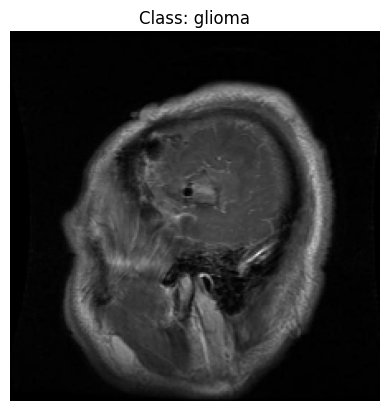

In [168]:
# Визуализация примера изображения из тренировочного набора
display_image_from_dataset(train_ds)

In [176]:
# import matplotlib.pyplot as plt
# from PIL import Image
# import tensorflow as tf

# # Пример для отображения одного изображения из train_ds
# for image_batch, label_batch in train_ds.take(1):  # Берём один батч
#     image = image_batch[0].numpy()  # Получаем первое изображение из батча
#     label = label_batch[0].numpy()  # Получаем метку первого изображения из батча

#     # Декодируем метку из one-hot в индекс
#     class_index = tf.argmax(label).numpy()
#     class_name = classes[class_index]  # Сопоставляем индекс с именем класса

#     # Отображаем изображение
#     plt.imshow(image.astype("uint8"))  # Преобразуем данные в формат uint8 для отображения
#     plt.title(f"Class: {class_name}")  # Добавляем название класса в заголовок
#     plt.axis('off')  # Убираем оси
#     plt.show()
#     break  # Прерываем, чтобы взять только один батч


In [149]:
# Преобразуем датасет в список для получения первых 5 элементов
data = list(train_ds.take(1))  # Возьмём первые 5 батчей
for image_batch, label_batch in data:
    for i in range(len(image_batch)):  # Проходим по изображениям внутри батча
        image = image_batch[i].numpy()  # Извлекаем изображение
        label_index = tf.argmax(label_batch[i]).numpy()  # Находим индекс класса
        print(image.shape, classes[label_index])  # Печатаем форму изображения и класс
        break

(224, 224, 3) glioma


In [ ]:
# # Преобразуем датасет в список для получения первых 5 элементов
# data = list(train_ds.take(1))  # Возьмём первые 5 батчей
# for image_batch, label_batch in data:
#     for i in range(len(image_batch)):  # Проходим по изображениям внутри батча
#         image = image_batch[i].numpy()  # Извлекаем изображение
#         label_index = tf.argmax(label_batch[i]).numpy()  # Находим индекс класса
#         print(image.shape, classes[label_index])  # Печатаем форму изображения и класс
#         break

(224, 224, 3) glioma


In [170]:
from collections import Counter

class_counts = Counter([label for _, label in all_images])
for cls, count in class_counts.items():
    print(f"{classes[cls]}: {count} images")

glioma: 1296 images
healthy: 1600 images
meningioma: 1316 images
pituitary: 1405 images


In [171]:
# Печатаем несколько изображений из train_ds, чтобы убедиться, что они перемешаны
for image_batch, label_batch in train_ds.take(1):  # Берем один батч
    for i in range(len(image_batch)):
        image = image_batch[i].numpy()
        label_index = tf.argmax(label_batch[i]).numpy()
        print(image.shape, classes[label_index])

(224, 224, 3) glioma
(224, 224, 3) glioma


In [172]:
import random
import numpy as np

# Преобразуем датасет в единый список изображений и меток
all_images = []
for image_batch, label_batch in train_ds:
    for i in range(len(image_batch)):
        image = image_batch[i].numpy()  # Извлекаем изображение
        label_index = tf.argmax(label_batch[i]).numpy()  # Находим индекс класса
        all_images.append((image, label_index))  # Сохраняем пару (изображение, класс)

# Случайно выбираем 5 изображений
random_samples = random.sample(all_images, 5)

# Выводим информацию о случайно выбранных изображениях
for image, label_index in random_samples:
    print(image.shape, classes[label_index])  # Печатаем форму изображения и класс


(224, 224, 3) pituitary
(224, 224, 3) glioma
(224, 224, 3) glioma
(224, 224, 3) healthy
(224, 224, 3) healthy


### 3. 🧠 Model Selection and Implementation:

In [30]:
# Define ResNet50 model components
def conv_block(x, filters, kernel_size, strides, padding='same'):
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def identity_block(x, filters):
    shortcut = x
    x = conv_block(x, filters=filters, kernel_size=(1, 1), strides=(1, 1))
    x = conv_block(x, filters=filters, kernel_size=(3, 3), strides=(1, 1))
    x = Conv2D(filters=filters * 4, kernel_size=(1, 1))(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def projection_block(x, filters, strides):
    shortcut = x
    x = conv_block(x, filters=filters, kernel_size=(1, 1), strides=strides)
    x = conv_block(x, filters=filters, kernel_size=(3, 3), strides=(1, 1))
    x = Conv2D(filters=filters * 4, kernel_size=(1, 1))(x)
    x = BatchNormalization()(x)
    shortcut = Conv2D(filters=filters * 4, kernel_size=(1, 1), strides=strides)(shortcut)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet50(input_shape=(224, 224, 3), num_classes=4):  # Adjusted num_classes for your dataset
    inputs = Input(shape=input_shape)
    

    # Initial conv layer
    x = conv_block(inputs, filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Conv block 1
    x = projection_block(x, filters=64, strides=(1, 1))
    x = identity_block(x, filters=64)
    x = identity_block(x, filters=64)

    # Conv block 2
    x = projection_block(x, filters=128, strides=(2, 2))
    x = identity_block(x, filters=128)
    x = identity_block(x, filters=128)
    x = identity_block(x, filters=128)

    # Conv block 3
    x = projection_block(x, filters=256, strides=(2, 2))
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)
    x = identity_block(x, filters=256)

    # Conv block 4
    x = projection_block(x, filters=512, strides=(2, 2))
    x = identity_block(x, filters=512)
    x = identity_block(x, filters=512)

    # Global average pooling and dense layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Build and compile the ResNet50 model
model = ResNet50(input_shape=(224, 224, 3), num_classes=4)  # Adjusted for 4 classes
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=1)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")

2809/2809 ━━━━━━━━━━━━━━━━━━━━ 1686s 586ms/step - accuracy: 0.4679 - loss: 1.5587 - val_accuracy: 0.6339 - val_loss: 0.8031
352/352 ━━━━━━━━━━━━━━━━━━━━ 39s 111ms/step - accuracy: 0.6529 - loss: 0.8264
Test accuracy: 0.6449


### 4. 🏋️‍♂️ Model Training and Evaluation:

In [ ]:
# # Train the model
# history = resnet_model.fit(
#     train_ds,
#     validation_data=validation_ds,
#     epochs=10
# )

# # Evaluate the model
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# plt.grid()
# plt.show()

### 5. 💡 Result Analysis:

In [ ]:
# # Test with a sample image
# sample_image_path = os.path.join(dataset_path, "glioma", "example.jpg")  # Replace with an actual image path
# image = cv2.imread(sample_image_path)
# image_resized = cv2.resize(image, (img_height, img_width))
# image = np.expand_dims(image_resized, axis=0)

# # Make predictions
# predictions = resnet_model.predict(image)
# predicted_class = class_names[np.argmax(predictions)]
# print(f"Predicted Class: {predicted_class}")